In [5]:
import sys, os
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator
import os.path
from IPython.display import Image, display, HTML
import pandas as pd
import random

PATH=os.path.expanduser("~/h2o-3/")
h2o.init(nthreads=-1)
if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,8 mins 29 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,7 hours and 14 minutes
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster free memory:,13.59 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


## Data Ingest
#### Image dataset
For simplicity, H2O Deep Water allows you to specify a list of URIs (file paths) or URLs (links) to images, together with a response column (either a class membership (enum) or regression target (numeric)).

For this example, we use this simple cat/dog/mouse dataset that has a few hundred images, and a label of cardinality 3.

In [44]:
frame = h2o.import_file(PATH + "/bigdata/laptop/deepwater/imagenet/cat_dog_mouse.csv")
print(frame.dim)
print(frame.head(5))

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%
[267, 2]


C1,C2
bigdata/laptop/deepwater/imagenet/cat/102194502_49f003abd9.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/11146807_00a5f35255.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/1140846215_70e326f868.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/114170569_6cbdf4bbdb.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/1217664848_de4c7fc296.jpg,cat


Let's look at a random subset of 10 images

['bigdata/laptop/deepwater/imagenet/dog/sniffles_dog.jpg', 'bigdata/laptop/deepwater/imagenet/cat/1350530984_ecf3039cf0.jpg', 'bigdata/laptop/deepwater/imagenet/dog/2047231704_fcc0270193.jpg', 'bigdata/laptop/deepwater/imagenet/mouse/Rodents_15detail.jpg', 'bigdata/laptop/deepwater/imagenet/dog/2.jpg', 'bigdata/laptop/deepwater/imagenet/mouse/153544881_42238780d7.jpg', 'bigdata/laptop/deepwater/imagenet/dog/1604197097_89259f9eb4.jpg', 'bigdata/laptop/deepwater/imagenet/mouse/90554914_2fca48b182.jpg', 'bigdata/laptop/deepwater/imagenet/dog/397889034_478565d7c2.jpg', 'bigdata/laptop/deepwater/imagenet/dog/12232378B~Perro-doguillo-Posteres.jpg']


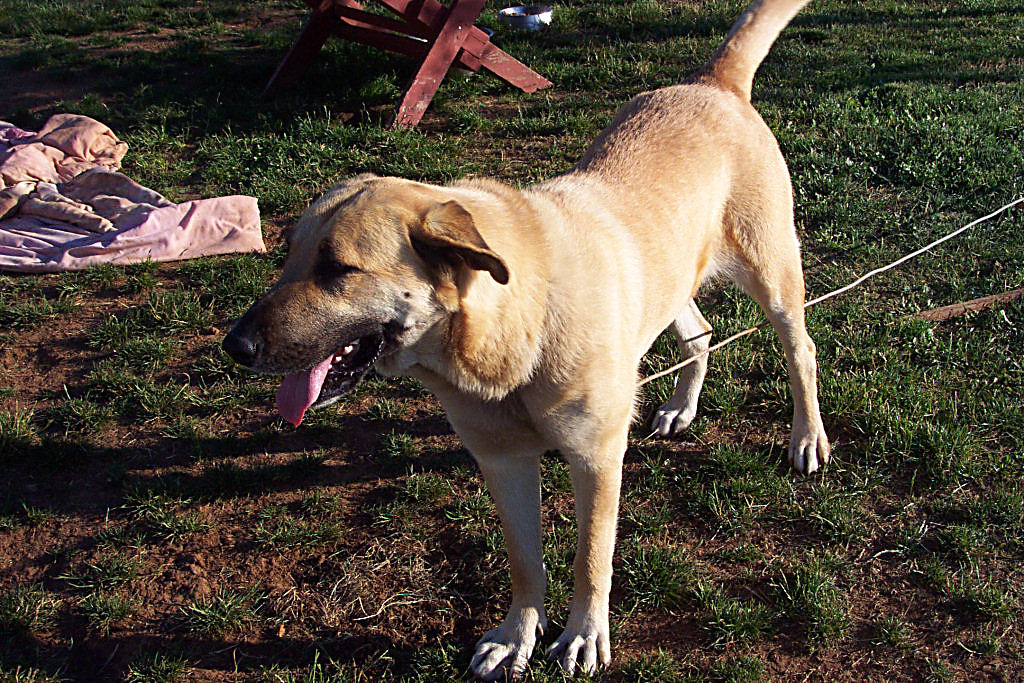

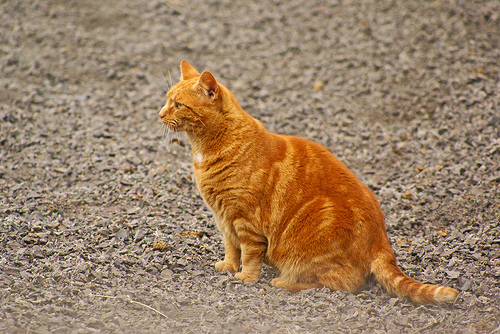

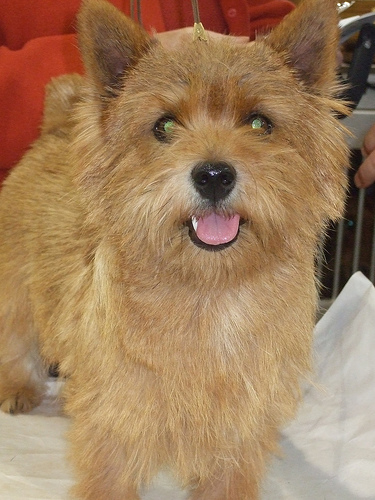

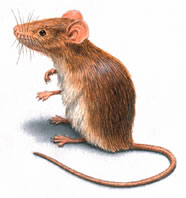

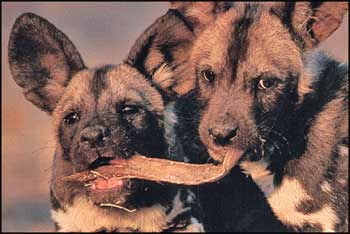

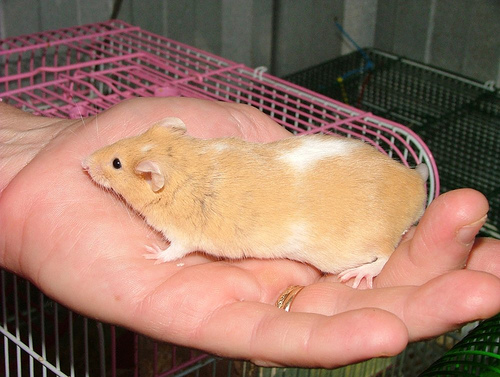

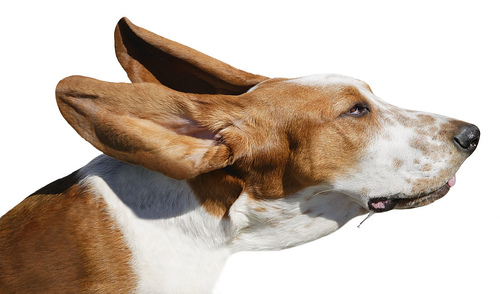

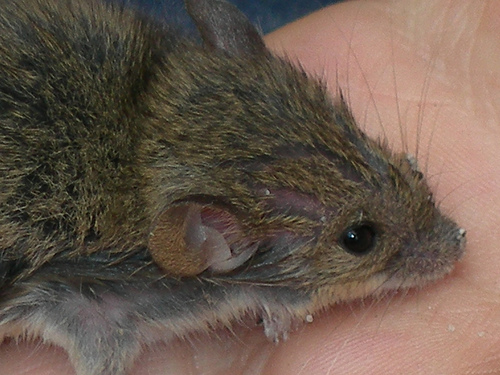

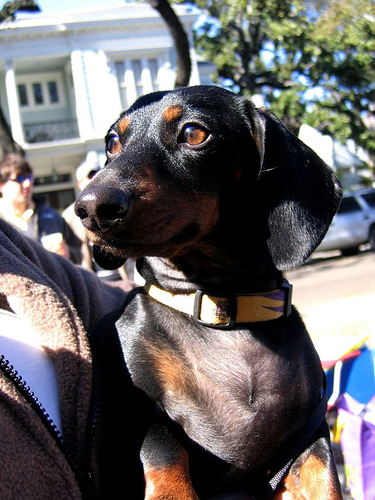

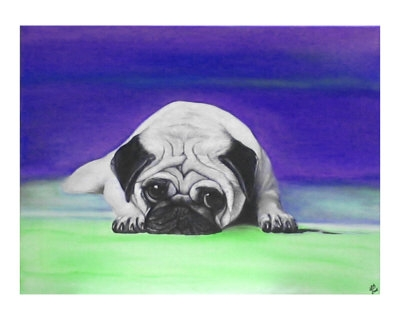

In [45]:
images = frame[:,0].as_data_frame(use_pandas=False)
which = list(random.sample(xrange(frame.nrow), 10))
sample = [images[x][0] for x in which]
print(sample)
for x in sample:
    display(Image(filename=PATH+x))

Now, we build a classic convolutional neural network, called [LeNet](http://yann.lecun.com/exdb/lenet/)
![LeNet](images/lenet.gif)
![LeNet](images/lenet.jpg)

We'll use a GPU to train such a LeNet model in seconds

In [19]:
!nvidia-smi

Sat Oct 22 18:50:12 2016       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.44                 Driver Version: 367.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980 Ti  Off  | 0000:01:00.0      On |                  N/A |
|  8%   62C    P0    77W / 275W |    993MiB /  6076MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 0000:02:00.0     Off |                  N/A |
| 31%   56C    P2    71W / 250W |   3810MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

To build a LeNet image classification model in H2O, simply specify network = "lenet":

In [46]:
model = H2ODeepWaterEstimator(epochs=500, network = "lenet")
model.train(x=[0],y=1, training_frame=frame)
model.show()

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%
Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477196242640_8
Status of Deep Learning Model: lenet, 1.6 MB, predicting C2, 3-class classification, 134,144 training samples, mini-batch size 32



,input_neurons,rate,momentum
,2352,0.0044086,0.99




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.016523414101
RMSE: 0.128543432742
LogLoss: 0.0602005034748
Mean Per-Class Error: 0.0226342710997
Confusion Matrix: vertical: actual; across: predicted



cat,dog,mouse,Error,Rate
90.0,0.0,0.0,0.0,0 / 90
1.0,82.0,2.0,0.0352941,3 / 85
3.0,0.0,89.0,0.0326087,3 / 92
94.0,82.0,91.0,0.0224719,6 / 267


Top-3 Hit Ratios: 


k,hit_ratio
1,0.9775281
2,0.9962547
3,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-22 22:09:36,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-22 22:09:37,1.162 sec,984 obs/sec,3.8352060,1,1024.0,0.6785243,1.2407866,0.6441948
,2016-10-22 22:09:42,6.229 sec,11918 obs/sec,272.2996255,71,72704.0,0.5219927,0.9131967,0.3595506
,2016-10-22 22:09:46,10.435 sec,13024 obs/sec,502.4119850,131,134144.0,0.1285434,0.0602005,0.0224719


If you'd like to build your own LeNet network architecture, then this is easy as well.
In this example script, we are using the 'mxnet' backend. Models can easily be imported/exported between H2O and MXNet since H2O uses MXNet's format for model definition.

In [6]:
def lenet(num_classes):
    import mxnet as mx
    data = mx.symbol.Variable('data')
    # first conv
    conv1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=20)
    tanh1 = mx.symbol.Activation(data=conv1, act_type="tanh")
    pool1 = mx.symbol.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
    # second conv
    conv2 = mx.symbol.Convolution(data=pool1, kernel=(5,5), num_filter=50)
    tanh2 = mx.symbol.Activation(data=conv2, act_type="tanh")
    pool2 = mx.symbol.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
    # first fullc
    flatten = mx.symbol.Flatten(data=pool2)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
    tanh3 = mx.symbol.Activation(data=fc1, act_type="tanh")
    # second fullc
    fc2 = mx.symbol.FullyConnected(data=tanh3, num_hidden=num_classes)
    # loss
    lenet = mx.symbol.SoftmaxOutput(data=fc2, name='softmax')
    return lenet

In [48]:
nclasses = frame[1].nlevels()[0]
lenet(nclasses).save("/tmp/symbol_lenet-py.json")

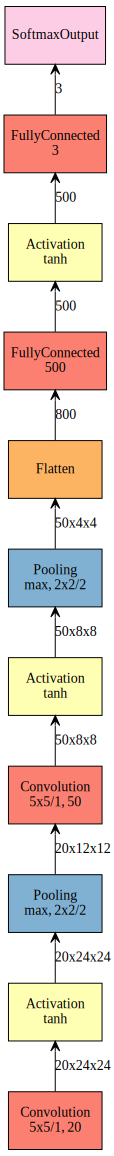

In [23]:
# pip install graphviz
# sudo apt-get install graphviz
import mxnet as mx
import graphviz
mx.viz.plot_network(lenet(3), shape={"data":(1, 1, 28, 28)}, node_attrs={"shape":'rect',"fixedsize":'false'})

In [49]:
model = H2ODeepWaterEstimator(epochs=500, ## early stopping is on by default and might trigger before
                              network_definition_file="/tmp/symbol_lenet-py.json",  ## specify the model
                              image_shape=[28,28],                                  ## provide expected (or matching) image size
                              channels=3)                                           ## 3 for color, 1 for monochrome
model.train(x=[0], y=1, training_frame=frame)
model.show()

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%
Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477196242640_9
Status of Deep Learning Model: user, 1.6 MB, predicting C2, 3-class classification, 134,144 training samples, mini-batch size 32



,input_neurons,rate,momentum
,2352,0.0044086,0.99




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 1.0633206616e-06
RMSE: 0.00103117440892
LogLoss: 0.000668403430702
Mean Per-Class Error: 0.0
Confusion Matrix: vertical: actual; across: predicted



cat,dog,mouse,Error,Rate
90.0,0.0,0.0,0.0,0 / 90
0.0,85.0,0.0,0.0,0 / 85
0.0,0.0,92.0,0.0,0 / 92
90.0,85.0,92.0,0.0,0 / 267


Top-3 Hit Ratios: 


k,hit_ratio
1,1.0
2,1.0
3,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-22 22:10:03,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-22 22:10:04,1.150 sec,990 obs/sec,3.8352060,1,1024.0,0.6624848,1.1650257,0.5842697
,2016-10-22 22:10:09,6.208 sec,14977 obs/sec,341.3333333,89,91136.0,0.5164604,0.9808768,0.3258427
,2016-10-22 22:10:11,8.539 sec,15950 obs/sec,502.4119850,131,134144.0,0.0010312,0.0006684,0.0


To see how much slower training a convolutional neural net is trained without a GPU, disable the 'gpu' flag. Note that using MKL or other optimized implementations of BLAS can make this difference shrink a lot, but generally a GPU is at least 5x faster than the best CPU implementations for realistic workloads, and often 50x faster or even more.

Instead of training for 500 epochs on the GPU, we'll train for 10 epochs on the CPU.

In [50]:
model = H2ODeepWaterEstimator(epochs=10,
                              network_definition_file="/tmp/symbol_lenet-py.json", 
                              image_shape=[28,28],
                              channels=3,
                              gpu = False)
model.train(x=[0], y=1, training_frame=frame)
model.show()

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%
Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477196242640_10
Status of Deep Learning Model: user, 1.6 MB, predicting C2, 3-class classification, 3,072 training samples, mini-batch size 32



,input_neurons,rate,momentum
,2352,0.0049847,0.927648




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.398013789377
RMSE: 0.630883340545
LogLoss: 1.03774429887
Mean Per-Class Error: 0.575063938619
Confusion Matrix: vertical: actual; across: predicted



cat,dog,mouse,Error,Rate
81.0,3.0,6.0,0.1,9 / 90
63.0,18.0,4.0,0.7882353,67 / 85
73.0,4.0,15.0,0.8369565,77 / 92
217.0,25.0,25.0,0.5730337,153 / 267


Top-3 Hit Ratios: 


k,hit_ratio
1,0.4269663
2,0.7977528
3,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-22 22:11:00,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-22 22:11:04,5.040 sec,221 obs/sec,3.8352060,1,1024.0,0.6308833,1.0377443,0.5730337
,2016-10-22 22:11:12,13.217 sec,245 obs/sec,11.5056180,3,3072.0,0.6567333,1.1964586,0.5805243
,2016-10-22 22:11:13,13.548 sec,245 obs/sec,11.5056180,3,3072.0,0.6308833,1.0377443,0.5730337
